https://docs.google.com/document/d/1SbG_ik_haXcKwjXVuvHvPhej0aHDRE8dY3296Cf7VQU/edit

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates

df = pd.read_csv("dataset1.csv")

df

,data,responsável,temperatura
0,sábado - 01/04/2023 00:00,Fábio,19.59
1,sábado - 01/04/2023 00:15,Fábio,19.10
2,sábado - 01/04/2023 00:30,Fábio,19.14
3,sábado - 01/04/2023 00:45,Fábio,18.55
4,sábado - 01/04/2023 01:00,Fábio,NaN
...,...,...,...
2875,domingo - 30/04/2023 22:45,Letícia,20.13
2876,domingo - 30/04/2023 23:00,Letícia,19.62
2877,domingo - 30/04/2023 23:15,Letícia,19.43
2878,domingo - 30/04/2023 23:30,Letícia,19.25


Item a)

In [29]:
def separar_coluna(df, nome_coluna):
  datetime = df[nome_coluna].str[-16:]
  dia_semana = df[nome_coluna].str[:-19]

  df["datetime"] = datetime
  df["dia da semana"] = dia_semana
  return df

separar_coluna(df, "data")
df["datetime"] = pd.to_datetime(df["datetime"], format='%d/%m/%Y %H:%M')

print(df.head())

                        data responsável  temperatura            datetime  \
0  sábado - 01/04/2023 00:00       Fábio        19.59 2023-04-01 00:00:00   
1  sábado - 01/04/2023 00:15       Fábio        19.10 2023-04-01 00:15:00   
2  sábado - 01/04/2023 00:30       Fábio        19.14 2023-04-01 00:30:00   
3  sábado - 01/04/2023 00:45       Fábio        18.55 2023-04-01 00:45:00   
4  sábado - 01/04/2023 01:00       Fábio          NaN 2023-04-01 01:00:00   

  dia da semana  
0        sábado  
1        sábado  
2        sábado  
3        sábado  
4        sábado  


Item b) Existem dados faltantes, percebidos pelos espaços vazios no meio das linhas do gráfico. Apesar disso, o formato dos gráficos para todos os dias desse mês são muito similares.

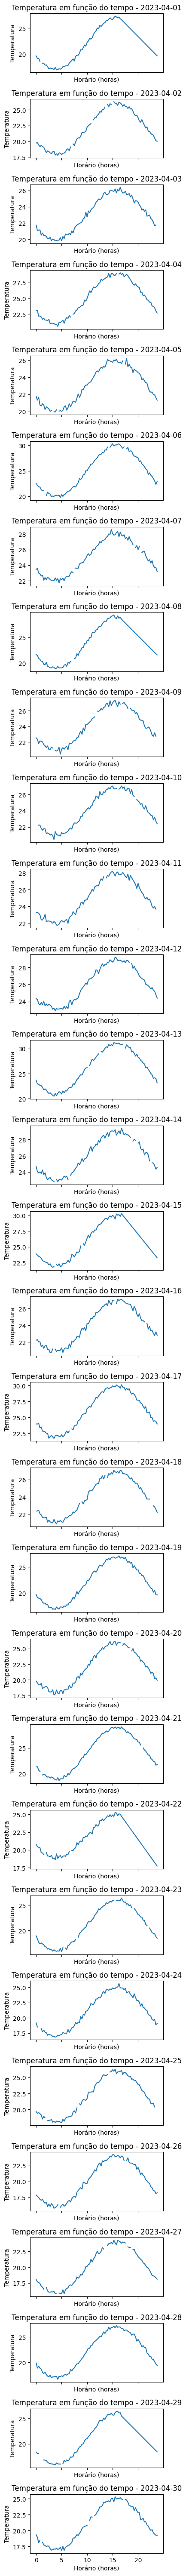

In [30]:
# Extrair o dia da coluna datetime
df['dia'] = df['datetime'].dt.date

# Extrair a hora da coluna datetime
df['hora'] = df['datetime'].dt.hour

# Obter a lista de dias únicos
dias_unicos = df['dia'].unique()

num_subplots = len(dias_unicos)
fig, axs = plt.subplots(num_subplots, 1, figsize=(4, 2*num_subplots), sharex=True)

for i, dia in enumerate(dias_unicos):
    dados_dia = df[df['dia'] == dia]

    # Converter o horário para horas
    horas = dados_dia['hora'] + dados_dia['datetime'].dt.minute / 60.0

    # Plotar o gráfico de temperatura em função do horário para o dia atual
    axs[i].plot(horas, dados_dia['temperatura'])
    axs[i].set_title(f'Temperatura em função do tempo - {dia}')
    axs[i].set_xlabel('Horário (horas)')
    axs[i].set_ylabel('Temperatura')

plt.tight_layout()
plt.show()


Item c) Em certas medições no período da noite, os dados de temperatura supostamente medidos pelo estudante são muito lineares, chegando a formar uma reta com o passar das horas. Esse comportamento do gráfico difícilmente seria observado na natureza.

Item d)

In [31]:
# Definir a coluna de datas como o índice do DataFrame
df.set_index('datetime', inplace=True)

# Imputar valores ausentes na coluna de temperatura
series = df['temperatura']

# Obter a frequência dos dados
frequency = series.index.inferred_freq

# Criar um novo DataFrame com índice de datas completas
complete_data = series.asfreq(frequency)

# Imputar valores ausentes usando o modelo SARIMA
model = SARIMAX(complete_data, order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))  # Ordem para medições mensais
model_fit = model.fit()

# Fazer previsões para os valores ausentes
predicted_values = model_fit.predict(start=df.index[0], end=df.index[-1])

# Substituir os valores ausentes pelos valores previstos
df.loc[df['temperatura'].isnull(), 'temperatura'] = predicted_values[df['temperatura'].isnull()]

print(df)

                                           data responsável  temperatura  \
datetime                                                                   
2023-04-01 00:00:00   sábado - 01/04/2023 00:00       Fábio    19.590000   
2023-04-01 00:15:00   sábado - 01/04/2023 00:15       Fábio    19.100000   
2023-04-01 00:30:00   sábado - 01/04/2023 00:30       Fábio    19.140000   
2023-04-01 00:45:00   sábado - 01/04/2023 00:45       Fábio    18.550000   
2023-04-01 01:00:00   sábado - 01/04/2023 01:00       Fábio    18.548518   
...                                         ...         ...          ...   
2023-04-30 22:45:00  domingo - 30/04/2023 22:45     Letícia    20.130000   
2023-04-30 23:00:00  domingo - 30/04/2023 23:00     Letícia    19.620000   
2023-04-30 23:15:00  domingo - 30/04/2023 23:15     Letícia    19.430000   
2023-04-30 23:30:00  domingo - 30/04/2023 23:30     Letícia    19.250000   
2023-04-30 23:45:00  domingo - 30/04/2023 23:45     Letícia    19.240000   

           

Item e) Quarta feira dia 26/04, tendo atingido a temperatura de 15.8 graus

In [32]:
df["dia da semana"].unique()

array(['sábado', 'domingo', 'segunda', 'terça', 'quarta', 'quinta',
       'sexta'], dtype=object)

In [33]:
# Filtrar apenas as quartas-feiras
quartas = df[df['dia da semana'] == 'quarta']

# Ordenar em ordem crescente de temperatura
quartas = quartas.sort_values(by='temperatura')

# Obter a quarta-feira mais fria
quarta_mais_fria = quartas.iloc[0]

print("Quarta-feira mais fria:")
print(quarta_mais_fria)

Quarta-feira mais fria:
data             quarta - 26/04/2023 03:30
responsável                          Fábio
temperatura                           15.8
dia da semana                       quarta
dia                             2023-04-26
hora                                     3
Name: 2023-04-26 03:30:00, dtype: object


Item f) Gráfico com as temperaturas interpoladas a fim de ter linhas suavizadas em sua imagem

              max        min
dia                         
2023-04-01  27.30  16.910000
2023-04-02  26.28  17.770000
2023-04-03  26.39  19.810000
2023-04-04  29.02  20.570000
2023-04-05  26.23  19.940000
2023-04-06  30.27  19.780000
2023-04-07  28.58  21.710000
2023-04-08  29.40  18.910000
2023-04-09  27.29  20.470000
2023-04-10  27.04  20.440000
2023-04-11  28.15  21.770000
2023-04-12  29.24  22.840000
2023-04-13  31.20  20.490000
2023-04-14  29.41  22.800000
2023-04-15  30.26  21.760000
2023-04-16  27.10  20.720000
2023-04-17  30.11  21.690000
2023-04-18  27.07  20.880000
2023-04-19  27.18  16.770000
2023-04-20  26.15  17.560000
2023-04-21  29.06  18.690000
2023-04-22  25.27  17.730000
2023-04-23  26.40  15.840000
2023-04-24  25.62  16.840000
2023-04-25  26.31  17.940000
2023-04-26  24.20  15.800000
2023-04-27  24.26  15.776179
2023-04-28  27.23  16.640000
2023-04-29  26.38  15.920000
2023-04-30  25.31  16.860000


<Figure size 700x300 with 0 Axes>

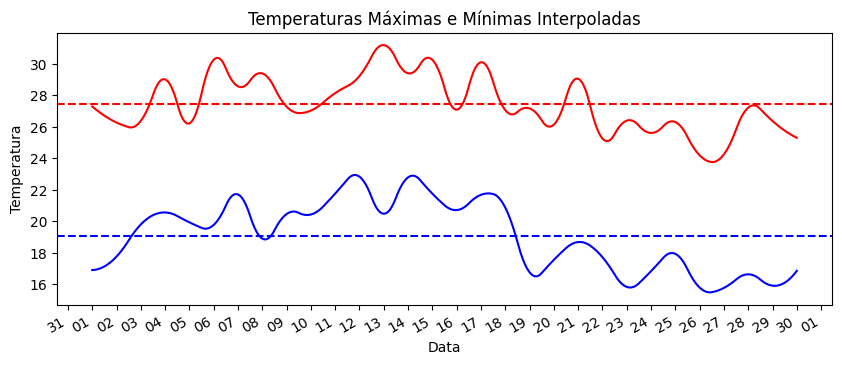

In [34]:
# Agrupar os dados por dia e calcular temperatura máxima e mínima
temperaturas_por_dia = df.groupby(df['dia'])['temperatura'].agg(['max', 'min'])

print(temperaturas_por_dia)

media_maxima = temperaturas_por_dia['max'].mean()
media_minima = temperaturas_por_dia['min'].mean()

plt.figure(figsize=(7, 3))

# Converter o índice para um DatetimeIndex
temperaturas_por_dia.index = pd.DatetimeIndex(temperaturas_por_dia.index)

# Interpolar os valores das temperaturas máximas e mínimas
data_interp = temperaturas_por_dia.resample('H').interpolate(method='quadratic')

# Criar o gráfico
plt.figure(figsize=(10, 4))
plt.plot(data_interp.index, data_interp['max'], color='red', label='Temperatura Máxima')
plt.plot(data_interp.index, data_interp['min'], color='blue', label='Temperatura Mínima')
plt.axhline(media_maxima, color='red', linestyle='--', label='Média Máxima')
plt.axhline(media_minima, color='blue', linestyle='--', label='Média Mínima')

plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.title('Temperaturas Máximas e Mínimas Interpoladas')

# Formatar o eixo x para exibir apenas o dia
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.gcf().autofmt_xdate()

plt.show()